# Intelligent Sampling for XAI Validation

Load predictions from batch processing, analyze and apply sampling strategy

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

sys.path.append('../src')
sys.path.append('../config')

from xai_pkg.sampling.utils import (
    load_predictions,
    export_sampled_predictions
)

from config import settings

output_dir = settings["OUTPUT_DIR"]

# Load predictions from batch processing
df_predictions, metadata = load_predictions()
print(f"Loaded {len(df_predictions)} predictions")

save_plots = True

Loaded 10000 predictions


In [2]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 12

# Chart styling
COLORS = {'original': 'lightblue', 'sampled': 'darkblue'}
ALPHA = 0.7
WIDTH = 0.35

## Analyze generated predictions, SHAP values and CFs

### 1. Prediction distribution

Total predictions: 10,000
Positive predictions (approved): 4,690 (46.9%)
Negative predictions (rejected): 5,310 (53.1%)


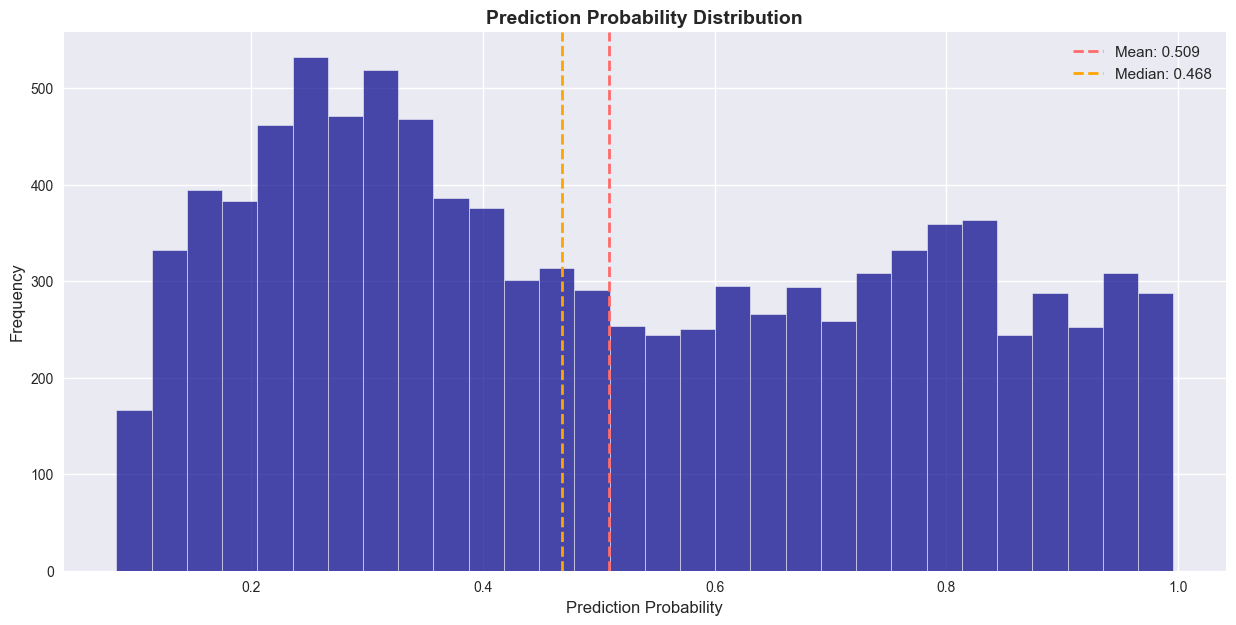


Probability Statistics:
Mean probability: 0.509
Median probability: 0.468
Std probability: 0.261
Min probability: 0.084
Max probability: 0.996

Boundary cases (0.45 ≤ p ≤ 0.55): 935 (9.3%)

Counterfactual Analysis by Prediction:
                mean       std  count
prediction                           
0           2.889266  0.349606   5310
1           2.873774  0.426083   4690


<Figure size 1500x700 with 0 Axes>

In [3]:
# Basic prediction statistics
total_predictions = len(df_predictions)
positive_predictions = (df_predictions['prediction'] == 1).sum()
negative_predictions = (df_predictions['prediction'] == 0).sum()
approval_rate = positive_predictions / total_predictions

print(f"Total predictions: {total_predictions:,}")
print(f"Positive predictions (approved): {positive_predictions:,} ({approval_rate:.1%})")
print(f"Negative predictions (rejected): {negative_predictions:,} ({(1-approval_rate):.1%})")


# 2. Probability Distribution (Histogram)
plt.figure()
plt.hist(df_predictions['probability'], bins=30, alpha=ALPHA, color = "darkblue", edgecolor='white', linewidth=0.5)
plt.axvline(df_predictions['probability'].mean(), color='#FF6B6B', linestyle='--', linewidth=2, 
            label=f'Mean: {df_predictions["probability"].mean():.3f}')
plt.axvline(df_predictions['probability'].median(), color='#FFA500', linestyle='--', linewidth=2, 
            label=f'Median: {df_predictions["probability"].median():.3f}')
plt.title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Prediction Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.show()
if save_plots:
    plt.savefig(f'{output_dir}/plots/probability_distribution.png')

# Print detailed statistics
print(f"\nProbability Statistics:")
print(f"Mean probability: {df_predictions['probability'].mean():.3f}")
print(f"Median probability: {df_predictions['probability'].median():.3f}")
print(f"Std probability: {df_predictions['probability'].std():.3f}")
print(f"Min probability: {df_predictions['probability'].min():.3f}")
print(f"Max probability: {df_predictions['probability'].max():.3f}")

boundary_cases = ((df_predictions['probability'] >= 0.45) & (df_predictions['probability'] <= 0.55)).sum()
print(f"\nBoundary cases (0.45 ≤ p ≤ 0.55): {boundary_cases:,} ({boundary_cases/total_predictions:.1%})")

print(f"\nCounterfactual Analysis by Prediction:")
cf_by_prediction = df_predictions.groupby('prediction')['cf_count'].agg(['mean', 'std', 'count'])
print(cf_by_prediction)

### 2. Counterfactuals generated

In [4]:
## Average number of counterfactuals per instance

import numpy as np
import matplotlib.pyplot as plt

# Analyze counterfactual generation statistics
print(f"Average number of counterfactuals per instance: {df_predictions['cf_count'].mean():.3f}")
print(f"Average percentile distance: {df_predictions['cf_avg_percentile_change'].mean():.3f}")

# Additional statistics
print(f"\nCounterfactual Statistics:")
print(f"Min counterfactuals: {df_predictions['cf_count'].min()}")
print(f"Max counterfactuals: {df_predictions['cf_count'].max()}")
print(f"Total instances with counterfactuals: {(df_predictions['cf_count'] > 0).sum()}")
print(f"Instances without counterfactuals: {(df_predictions['cf_count'] == 0).sum()}")
print(f"\nDistribution:")
print(df_predictions['cf_count'].value_counts().sort_index())

Average number of counterfactuals per instance: 2.882
Average percentile distance: 11.286

Counterfactual Statistics:
Min counterfactuals: 1
Max counterfactuals: 3
Total instances with counterfactuals: 10000
Instances without counterfactuals: 0

Distribution:
cf_count
1     230
2     720
3    9050
Name: count, dtype: int64


## Set up sampling strategy for LLM explanations

In [ ]:
import sys
sys.path.append('../src')
from xai_pkg.sampling.utils import categorize_by_probability, stratified_sample_with_targets

# Define probability boundaries
PROBABILITY_BINS = [0, 0.3, 0.45, 0.55, 0.7, 1.0]
CATEGORY_LABELS = ['CLEAR_ACCEPT', 'LEAN_ACCEPT', 'BOUNDARY', 'LEAN_REJECT', 'CLEAR_REJECT']

# Define how many samples from each category
SAMPLING_TARGETS = {
    'CLEAR_REJECT': 20,
    'LEAN_REJECT': 20,
    'BOUNDARY': 35,        # Most important for XAI evaluation
    'LEAN_ACCEPT': 5,    
    'CLEAR_ACCEPT': 5,    
}

# Total samples 
TOTAL_SAMPLES = 100


# Step 1: Categorize all predictions and add age groups
df_with_categories = categorize_by_probability(
    df_predictions.copy(), 
    bins=PROBABILITY_BINS,
    labels=CATEGORY_LABELS
)

# Add age groups for stratification
def create_age_groups(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 36:
        return 'Young Adult (21-35)'
    elif age < 51:
        return 'Middle Age (36-50)'
    elif age < 66:
        return 'Mature (51-65)'
    else:
        return 'Senior (>66)'

df_with_categories['age_group'] = df_with_categories['input_age'].apply(create_age_groups)

# Step 2: Perform stratified sampling with age group preservation
df_sampled = stratified_sample_with_targets(
    df_with_categories,
    sampling_targets=SAMPLING_TARGETS,
    total_samples=TOTAL_SAMPLES,
    preserve_age_groups=True
)

# Export sampled predictions for detailed analysis
sample_file = export_sampled_predictions(df_sampled, output_dir="../output/predictions", filename="prediction_results_sampled.json")

# Verification
print(f"\nTotal samples selected: {len(df_sampled)}")
print(f"\nCategory distribution:")
print(df_sampled['sampling_category'].value_counts())
print(f"\nProbability range: {df_sampled['probability'].min():.3f} - {df_sampled['probability'].max():.3f}")

Preserving age group proportions: {'Mature (51-65)': 0.3461, 'Middle Age (36-50)': 0.319, 'Senior (>66)': 0.1938, 'Young Adult (21-35)': 0.1411}
🎯 Using age-first stratification
  Mature (51-65): 3461 available → target 34
  Middle Age (36-50): 3190 available → target 31
  Senior (>66): 1938 available → target 19
  Young Adult (21-35): 1411 available → target 16
✅ Exported 100 sampled predictions to: ../output/predictions/prediction_results_sampled.json

Total samples selected: 100

Category distribution:
sampling_category
BOUNDARY        39
CLEAR_REJECT    25
LEAN_REJECT     23
CLEAR_ACCEPT     7
LEAN_ACCEPT      6
Name: count, dtype: int64

Probability range: 0.157 - 0.983


📈 Kolmogorov-Smirnov test for probability distributions:
   KS statistic: 0.3526, p-value: 0.0000
   ⚠️ Distributions differ significantly


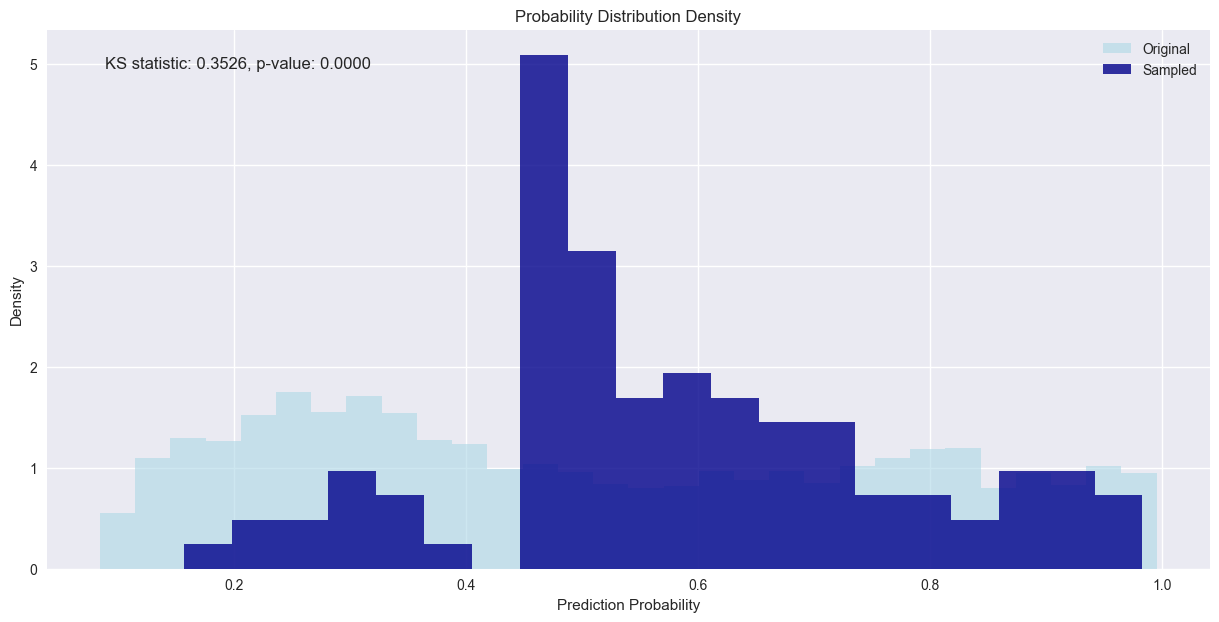

<Figure size 1500x700 with 0 Axes>

In [6]:
# Print statistical test
ks_stat, ks_p = stats.ks_2samp(df_predictions['probability'], df_sampled['probability'])
print(f"📈 Kolmogorov-Smirnov test for probability distributions:")
print(f"   KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
print(f"   {'✅ Distributions are similar' if ks_p > 0.05 else '⚠️ Distributions differ significantly'}")


# Probability histogram comparison (separate chart)
fig_hist, ax_hist = plt.subplots()
ax_hist.hist(df_predictions['probability'], bins=30, alpha=0.6, label='Original', density=True, color=COLORS['original'])
ax_hist.hist(df_sampled['probability'], bins=20, alpha=0.8, label='Sampled', density=True, color=COLORS['sampled'])
ax_hist.set_title('Probability Distribution Density')
ax_hist.set_xlabel('Prediction Probability')
ax_hist.set_ylabel('Density')
# Add ks test results to the plot
ax_hist.text(0.05, 0.95, f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}", transform=ax_hist.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)
ax_hist.legend()
plt.show()
if save_plots:
    plt.savefig(f'{output_dir}/plots/probability_distribution_comparison.png')



## Age Group Analysis

KS statistic: 0.0426, p-value: 0.9906
✅ Age distributions are similar
👥 Age Group Sampling Analysis:
--------------------------------------------------

Prediction dataset age range: 21.0 - 104.0
Young Adult (21-35) : predictions: 14.1%, Sampled: 16.0%, Diff: 1.9%
Middle Age (36-50)  : predictions: 31.9%, Sampled: 31.0%, Diff: 0.9%
Mature (51-65)      : predictions: 34.6%, Sampled: 34.0%, Diff: 0.6%
Senior (>66)        : predictions: 19.4%, Sampled: 19.0%, Diff: 0.4%


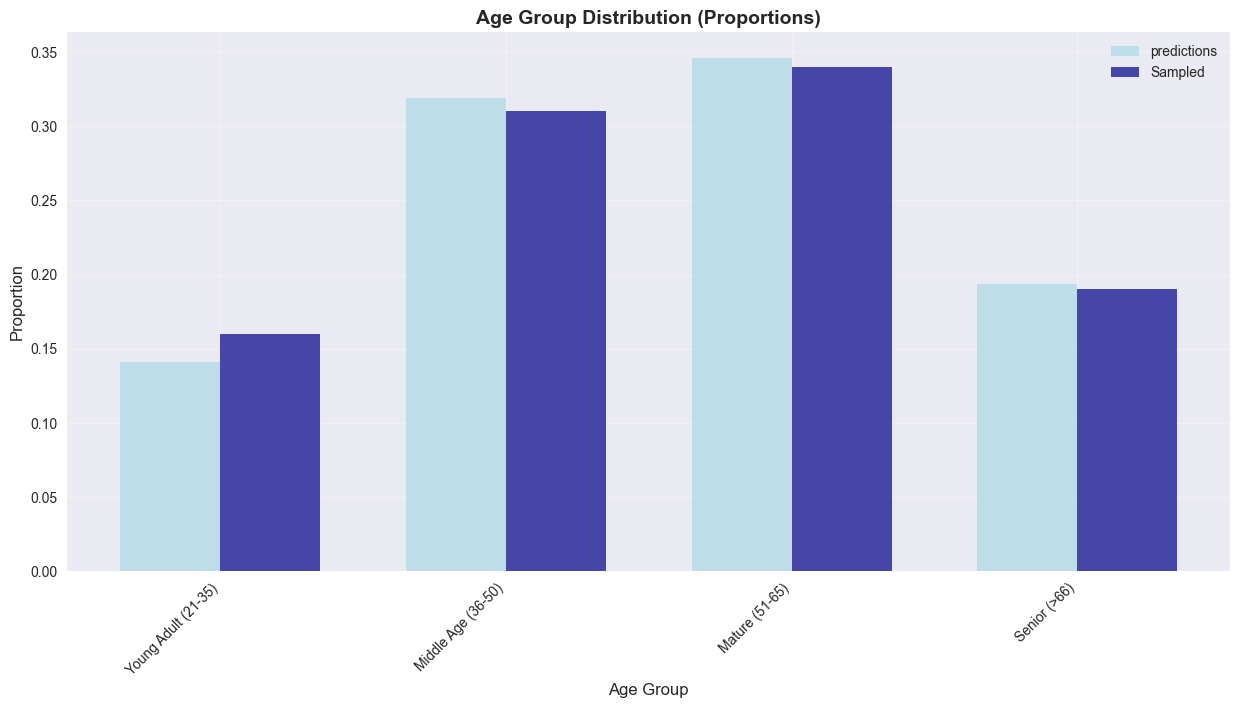

<Figure size 1500x700 with 0 Axes>

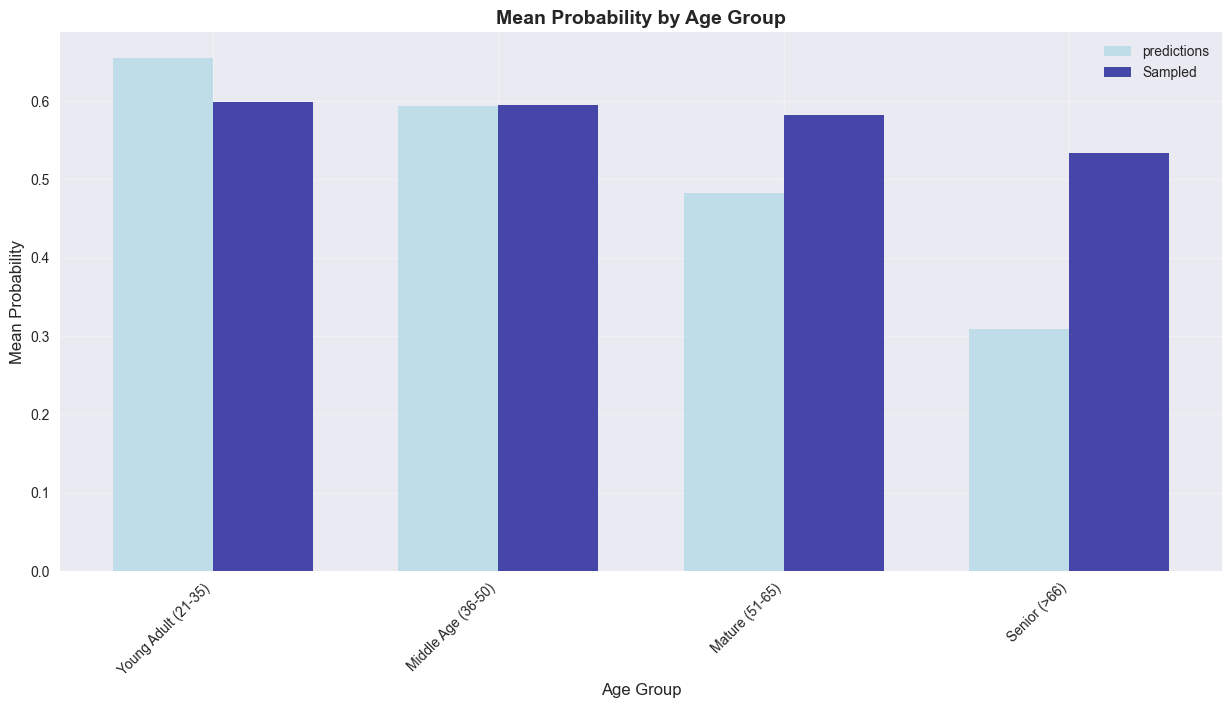

<Figure size 1500x700 with 0 Axes>

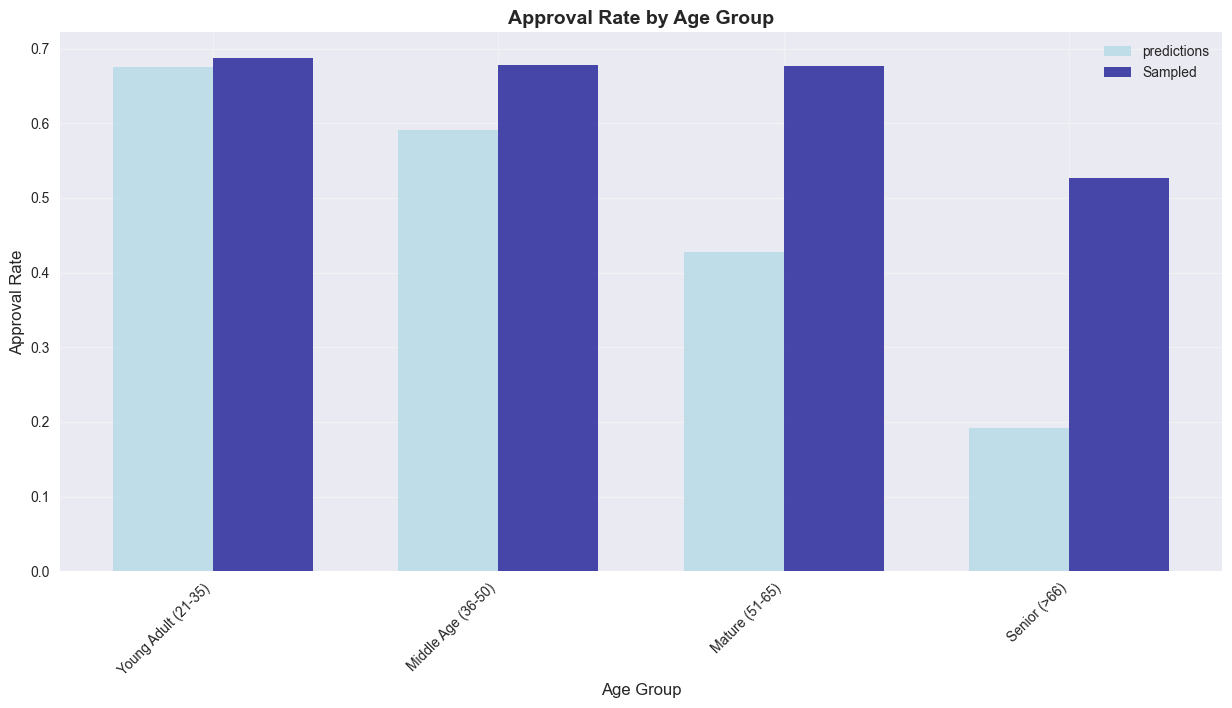

<Figure size 1500x700 with 0 Axes>

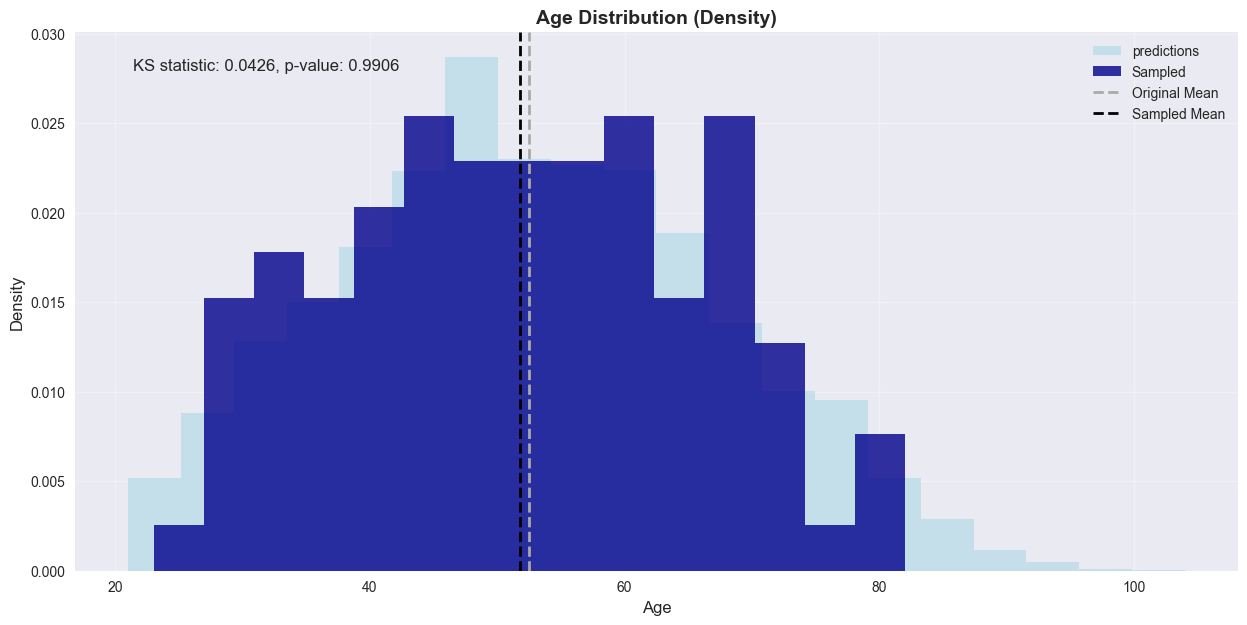

<Figure size 1500x700 with 0 Axes>

In [7]:
# 3. AGE GROUP ANALYSIS

# Create age groups for analysis
def create_age_groups(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 36:
        return 'Young Adult (21-35)'
    elif age < 51:
        return 'Middle Age (36-50)'
    elif age < 66:
        return 'Mature (51-65)'
    else:
        return 'Senior (>66)'

df_predictions['age_group'] = df_predictions['input_age'].apply(create_age_groups)
df_sampled['age_group'] = df_sampled['input_age'].apply(create_age_groups)

# Setup data
ordered_age_groups = ['Young Adult (21-35)', 'Middle Age (36-50)', 'Mature (51-65)', 'Senior (>66)', 'Unknown']
age_orig = df_predictions['age_group'].value_counts()
age_samp = df_sampled['age_group'].value_counts()
all_age_groups = [g for g in ordered_age_groups if g in set(age_orig.index) | set(age_samp.index)]
age_orig = age_orig.reindex(all_age_groups, fill_value=0)
age_samp = age_samp.reindex(all_age_groups, fill_value=0)
x = np.arange(len(all_age_groups))

df_orig_age_clean = df_predictions[df_predictions['input_age'].notna()]
df_samp_age_clean = df_sampled[df_sampled['input_age'].notna()]
age_prob_orig = df_predictions.groupby('age_group')['probability'].mean().reindex(all_age_groups, fill_value=0)
age_prob_samp = df_sampled.groupby('age_group')['probability'].mean().reindex(all_age_groups, fill_value=0)
age_pred_orig = df_predictions.groupby('age_group')['prediction'].mean().reindex(all_age_groups, fill_value=0)
age_pred_samp = df_sampled.groupby('age_group')['prediction'].mean().reindex(all_age_groups, fill_value=0)
age_orig_prop = age_orig / age_orig.sum()
age_samp_prop = age_samp / age_samp.sum()

# Statistical test for age distributions
if len(df_orig_age_clean) > 0 and len(df_samp_age_clean) > 0:
    age_ks_stat, age_ks_p = stats.ks_2samp(df_orig_age_clean['input_age'], df_samp_age_clean['input_age'])
    print(f"KS statistic: {age_ks_stat:.4f}, p-value: {age_ks_p:.4f}")
    print(f"{'✅ Age distributions are similar' if age_ks_p > 0.05 else '⚠️ Age distributions differ significantly'}")

    # Age group sampling analysis
print("👥 Age Group Sampling Analysis:")
print("-" * 50)
print(f"\nPrediction dataset age range: {df_orig_age_clean['input_age'].min()} - {df_orig_age_clean['input_age'].max()}")
for age_group in all_age_groups:
    orig_count = len(df_predictions[df_predictions['age_group'] == age_group])
    samp_count = len(df_sampled[df_sampled['age_group'] == age_group])
    orig_prop = orig_count / len(df_predictions)
    samp_prop = samp_count / len(df_sampled)
    prop_diff = abs(orig_prop - samp_prop)
    print(f"{age_group:20}: predictions: {orig_prop:.1%}, Sampled: {samp_prop:.1%}, Diff: {prop_diff:.1%}")

# 1. Age Group Distribution (Proportions)
plt.figure()
plt.bar(x - WIDTH/2, age_orig_prop.values, WIDTH, label='predictions', alpha=ALPHA, color=COLORS['original'])
plt.bar(x + WIDTH/2, age_samp_prop.values, WIDTH, label='Sampled', alpha=ALPHA, color=COLORS['sampled'])
plt.title('Age Group Distribution (Proportions)', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(x, all_age_groups, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
if save_plots:
    plt.savefig(f'{output_dir}/plots/age_distribution_proportions.png')

# 2. Mean Probability by Age Group
plt.figure()
plt.bar(x - WIDTH/2, age_prob_orig.values, WIDTH, label='predictions', alpha=ALPHA, color=COLORS['original'])
plt.bar(x + WIDTH/2, age_prob_samp.values, WIDTH, label='Sampled', alpha=ALPHA, color=COLORS['sampled'])
plt.title('Mean Probability by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Mean Probability', fontsize=12)
plt.xticks(x, all_age_groups, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
if save_plots:
    plt.savefig(f'{output_dir}/plots/age_distribution_mean_probability.png')

# 3. Approval Rate by Age Group
plt.figure()
plt.bar(x - WIDTH/2, age_pred_orig.values, WIDTH, label='predictions', alpha=ALPHA, color=COLORS['original'])
plt.bar(x + WIDTH/2, age_pred_samp.values, WIDTH, label='Sampled', alpha=ALPHA, color=COLORS['sampled'])
plt.title('Approval Rate by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Approval Rate', fontsize=12)
plt.xticks(x, all_age_groups, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
if save_plots:
    plt.savefig(f'{output_dir}/plots/age_distribution_approval_rate.png')

# 4. Age Distribution (Histogram)
plt.figure()
plt.hist(df_orig_age_clean['input_age'], bins=20, alpha=0.6, label='predictions', density=True, color=COLORS['original'])
plt.hist(df_samp_age_clean['input_age'], bins=15, alpha=0.8, label='Sampled', density=True, color=COLORS['sampled'])
# Add original and sampled mean ages to the plot
plt.axvline(df_orig_age_clean['input_age'].mean(), color="darkgrey", linestyle='--', linewidth=2, label='Original Mean')
plt.axvline(df_samp_age_clean['input_age'].mean(), color="black", linestyle='--', linewidth=2, label='Sampled Mean')
plt.title('Age Distribution (Density)', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
# Add ks test results to the plot
plt.text(0.05, 0.95, f"KS statistic: {age_ks_stat:.4f}, p-value: {age_ks_p:.4f}", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
if save_plots:
    plt.savefig(f'{output_dir}/plots/age_distribution.png')



In [8]:
# Analyze counterfactual generation statistics
print(f"Average number of counterfactuals per instance: {df_predictions['cf_count'].mean():.3f}")
print(f"Average percentile distance: {df_predictions['cf_avg_percentile_change'].mean():.3f}")

# Additional statistics
print(f"\nCounterfactual Statistics:")
print(f"Min counterfactuals: {df_predictions['cf_count'].min()}")
print(f"Max counterfactuals: {df_predictions['cf_count'].max()}")
print(f"Total instances with counterfactuals: {(df_predictions['cf_count'] > 0).sum()}")
print(f"Instances without counterfactuals: {(df_predictions['cf_count'] == 0).sum()}")
print(f"\nDistribution:")
print(df_predictions['cf_count'].value_counts().sort_index())

Average number of counterfactuals per instance: 2.882
Average percentile distance: 11.286

Counterfactual Statistics:
Min counterfactuals: 1
Max counterfactuals: 3
Total instances with counterfactuals: 10000
Instances without counterfactuals: 0

Distribution:
cf_count
1     230
2     720
3    9050
Name: count, dtype: int64


In [9]:
import openpyxl

# Overall sampling statistics
print("\n1. OVERALL SAMPLING EFFECTIVENESS")
print("-" * 50)
print(f"Original dataset size:        {len(df_predictions):,} predictions")
print(f"Sampled dataset size:         {len(df_sampled):,} predictions")
print(f"Sampling ratio:               {len(df_sampled)/len(df_predictions):.1%}")
print(f"Data reduction:               {(1-len(df_sampled)/len(df_predictions)):.1%}")

# Distribution preservation metrics
orig_approval_rate = df_predictions['prediction'].mean()
samp_approval_rate = df_sampled['prediction'].mean()
approval_diff = abs(orig_approval_rate - samp_approval_rate)

orig_mean_prob = df_predictions['probability'].mean()
samp_mean_prob = df_sampled['probability'].mean()
prob_diff = abs(orig_mean_prob - samp_mean_prob)

print(f"\nApproval rate preservation:")
print(f"  Original:                   {orig_approval_rate:.3f}")
print(f"  Sampled:                    {samp_approval_rate:.3f}")
print(f"  Absolute difference:        {approval_diff:.3f}")
print(f"  Relative difference:        {approval_diff/orig_approval_rate:.1%}")

print(f"\nProbability distribution preservation:")
print(f"  Original mean:              {orig_mean_prob:.3f}")
print(f"  Sampled mean:               {samp_mean_prob:.3f}")
print(f"  Absolute difference:        {prob_diff:.3f}")
print(f"  Relative difference:        {prob_diff/orig_mean_prob:.1%}")

# Cluster representation analysis
print(f"\n2. CLUSTER REPRESENTATION ANALYSIS")
print("-" * 50)
df_orig_clusters = df_predictions[df_predictions['cluster_id'].notna()]
df_samp_clusters = df_sampled[df_sampled['cluster_id'].notna()]

cluster_stats = []
for cluster_id in sorted(df_orig_clusters['cluster_id'].unique()):
    if not pd.isna(cluster_id):
        orig_count = len(df_orig_clusters[df_orig_clusters['cluster_id'] == cluster_id])
        samp_count = len(df_samp_clusters[df_samp_clusters['cluster_id'] == cluster_id])
        orig_pct = orig_count / len(df_orig_clusters) * 100
        samp_pct = samp_count / len(df_samp_clusters) * 100
        sampling_rate = samp_count / orig_count * 100
        
        cluster_stats.append({
            'Cluster': int(cluster_id),
            'Original Count': orig_count,
            'Original %': orig_pct,
            'Sampled Count': samp_count,
            'Sampled %': samp_pct,
            'Sampling Rate': sampling_rate,
            'Representation Diff': abs(samp_pct - orig_pct)
        })

cluster_df = pd.DataFrame(cluster_stats)
print(cluster_df.to_string(index=False, float_format='%.1f'))

# Age group representation analysis
print(f"\n3. AGE GROUP REPRESENTATION ANALYSIS")
print("-" * 50)
age_stats = []
for age_group in ['Young Adult (21-35)', 'Middle Age (36-50)', 'Mature (51-65)', 'Senior (>66)', 'Unknown']:
    orig_count = len(df_predictions[df_predictions['age_group'] == age_group])
    samp_count = len(df_sampled[df_sampled['age_group'] == age_group])
    
    if orig_count > 0:
        orig_pct = orig_count / len(df_predictions) * 100
        samp_pct = samp_count / len(df_sampled) * 100
        sampling_rate = samp_count / orig_count * 100
        
        age_stats.append({
            'Age Group': age_group,
            'Original Count': orig_count,
            'Original %': orig_pct,
            'Sampled Count': samp_count,
            'Sampled %': samp_pct,
            'Sampling Rate': sampling_rate,
            'Representation Diff': abs(samp_pct - orig_pct)
        })

age_df = pd.DataFrame(age_stats)
print(age_df.to_string(index=False, float_format='%.1f'))

# Risk profile preservation
print(f"\n4. RISK PROFILE PRESERVATION")
print("-" * 50)

# High risk (low probability)
high_risk_orig = len(df_predictions[df_predictions['probability'] < 0.3])
high_risk_samp = len(df_sampled[df_sampled['probability'] < 0.3])

# Medium risk
med_risk_orig = len(df_predictions[(df_predictions['probability'] >= 0.3) & (df_predictions['probability'] <= 0.7)])
med_risk_samp = len(df_sampled[(df_sampled['probability'] >= 0.3) & (df_sampled['probability'] <= 0.7)])

# Low risk (high probability)
low_risk_orig = len(df_predictions[df_predictions['probability'] > 0.7])
low_risk_samp = len(df_sampled[df_sampled['probability'] > 0.7])

risk_data = {
    'Risk Level': ['High Risk (p<0.3)', 'Medium Risk (0.3≤p≤0.7)', 'Low Risk (p>0.7)'],
    'Original Count': [high_risk_orig, med_risk_orig, low_risk_orig],
    'Original %': [high_risk_orig/len(df_predictions)*100, med_risk_orig/len(df_predictions)*100, low_risk_orig/len(df_predictions)*100],
    'Sampled Count': [high_risk_samp, med_risk_samp, low_risk_samp],
    'Sampled %': [high_risk_samp/len(df_sampled)*100, med_risk_samp/len(df_sampled)*100, low_risk_samp/len(df_sampled)*100]
}

risk_df = pd.DataFrame(risk_data)
risk_df['Representation Diff'] = abs(risk_df['Sampled %'] - risk_df['Original %'])
print(risk_df.to_string(index=False, float_format='%.1f'))

# Combine all stats and save to different excel tabs
stats_df = pd.concat([cluster_df, age_df, risk_df], axis=0)
stats_df.to_excel(f'{output_dir}/sampling_stats.xlsx', index=False)


1. OVERALL SAMPLING EFFECTIVENESS
--------------------------------------------------
Original dataset size:        10,000 predictions
Sampled dataset size:         100 predictions
Sampling ratio:               1.0%
Data reduction:               99.0%

Approval rate preservation:
  Original:                   0.469
  Sampled:                    0.650
  Absolute difference:        0.181
  Relative difference:        38.6%

Probability distribution preservation:
  Original mean:              0.509
  Sampled mean:               0.579
  Absolute difference:        0.070
  Relative difference:        13.8%

2. CLUSTER REPRESENTATION ANALYSIS
--------------------------------------------------
 Cluster  Original Count  Original %  Sampled Count  Sampled %  Sampling Rate  Representation Diff
       0            5430        54.3             46       46.0            0.8                  8.3
       1            1267        12.7             12       12.0            0.9                  0.7
       